In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.calibration import calibration_curve
from statkit.decision import NetBenefitDisplay

# 解决中文问题
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 1.读取数据
tData_train = pd.read_csv("data/ttest_data.csv", encoding='utf-8-sig')
select_features = []
with open("./data/五折/features.txt", "r") as f:
       for feature in f.readlines():
              select_features.append(str(feature).strip())
# print(select_features)
X = tData_train[select_features]
y = tData_train['label']

# 2. 分割数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 3. 标准化
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [2]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier



models = {
    "Logistic Regression": LogisticRegression(solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=0),
    "SVM": SVC(probability=True, random_state=0),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "AdaBoost": AdaBoostClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "XGBoost": XGBClassifier(random_state=0),
    "LightGBM": LGBMClassifier(random_state=0)
}
# 存储评估指标
metrics = {}
probabilities = {}

# 训练模型并计算评估指标
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # 对于非概率模型（如决策树），predict_proba可能不可用，因此需要处理这种情况
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_prob = None
    # 计算评估指标
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, labels=(0, 1), target_names=("良性", "恶性"))
    
    # 保存指标
    probabilities[name] = y_prob
    metrics[name] = {
        "accuracy score": acc,
        "precision score": precision,
        "recall score": recall,
        "F1 score": f1,
        "confusion matrix": conf_matrix,
        "classification report": report
    }

# 输出评估指标
for name, metric in metrics.items():
    print(f"{name} 的评估指标:")
    print(f"accuracy score: {metric['accuracy score']:.2f}")
    print(f"precision score: {metric['precision score']:.2f}")
    print(f"recall score: {metric['recall score']:.2f}")
    print(f"F1 score: {metric['F1 score']:.2f}")
    print(f"confusion matrix:\n{metric['confusion matrix']}\n")
    print(f"classification report:\n{metric['classification report']}\n")

[LightGBM] [Info] Number of positive: 557, number of negative: 4262
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21271
[LightGBM] [Info] Number of data points in the train set: 4819, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115584 -> initscore=-2.034929
[LightGBM] [Info] Start training from score -2.034929
Logistic Regression 的评估指标:
accuracy score: 0.92
precision score: 0.72
recall score: 0.53
F1 score: 0.61
confusion matrix:
[[1789   47]
 [ 109  121]]

classification report:
              precision    recall  f1-score   support

          良性       0.94      0.97      0.96      1836
          恶性       0.72      0.53      0.61       230

    accuracy                           0.92      2066
   macro avg       0.83      0.75      0.78      2066
weighted avg       0.92      0.92      0.92      2066


Random F

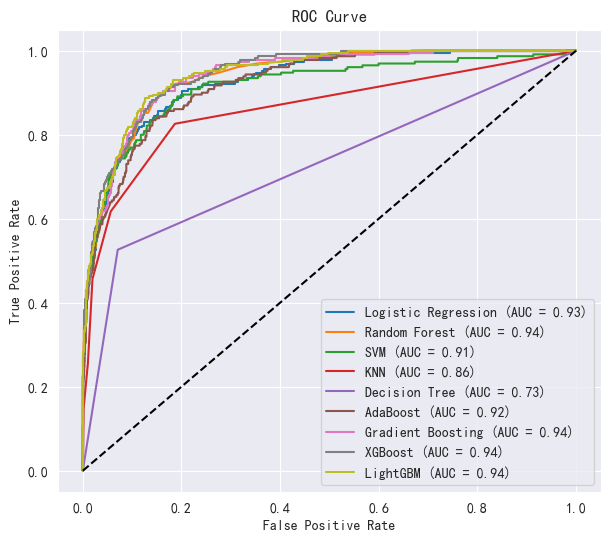

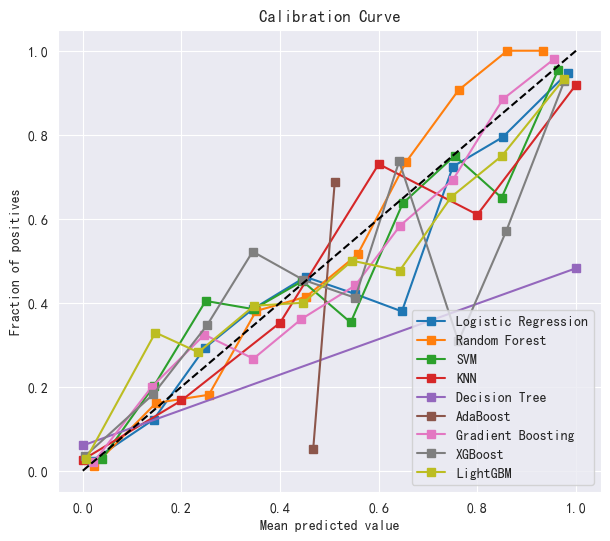

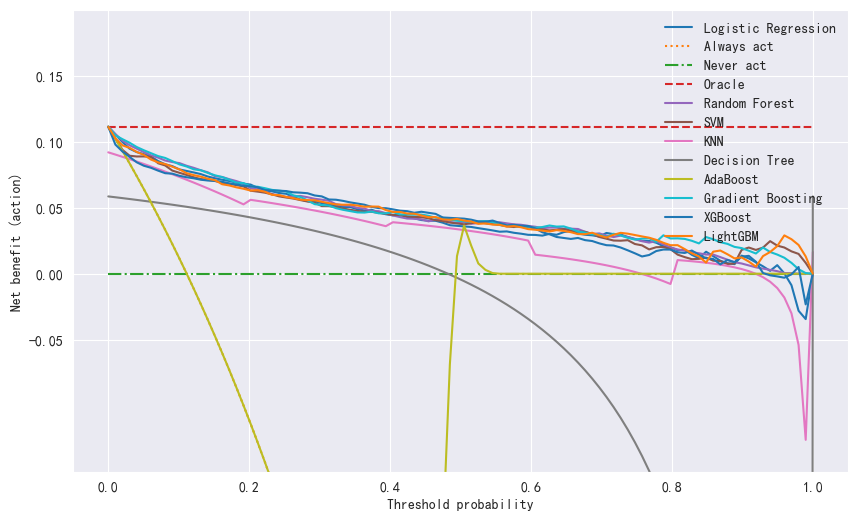

In [3]:


# 5. 绘制ROC曲线
plt.figure(figsize=(7, 6))

# ROC曲线

for name, model in models.items():
    # model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]  # 获取正类的概率
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# 6. 绘制校准曲线

plt.figure(figsize=(7, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Mean predicted value')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend(loc='lower right')
plt.show()

# 7. 绘制决策曲线
plt.figure(figsize=(10, 6))

# 收集每个模型的预测概率
n = 0
for name, model in models.items():
    y_pred_base = model.predict_proba(X_test)[:, 1]  # 获取正类的概率
    if n == 0:  # 第一个模型绘制参考线
        NetBenefitDisplay.from_predictions(y_test, y_pred_base, name=name, ax=plt.gca(), show_references=True)
    else:   # 其他模型绘制不绘制参考线及标签
        NetBenefitDisplay.from_predictions(y_test, y_pred_base, name=name, ax=plt.gca(), show_references=False)
    n += 1
y_ticks = np.arange(-0.05, 0.2, 0.05)
plt.yticks(y_ticks)
plt.ylim(-0.15, 0.2)
# plt.legend(loc='lower right')
plt.show()



[LightGBM] [Info] Number of positive: 557, number of negative: 4262
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21271
[LightGBM] [Info] Number of data points in the train set: 4819, number of used features: 84
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.115584 -> initscore=-2.034929
[LightGBM] [Info] Start training from score -2.034929


D:\Miniconda\envs\DL\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)
D:\Miniconda\envs\DL\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


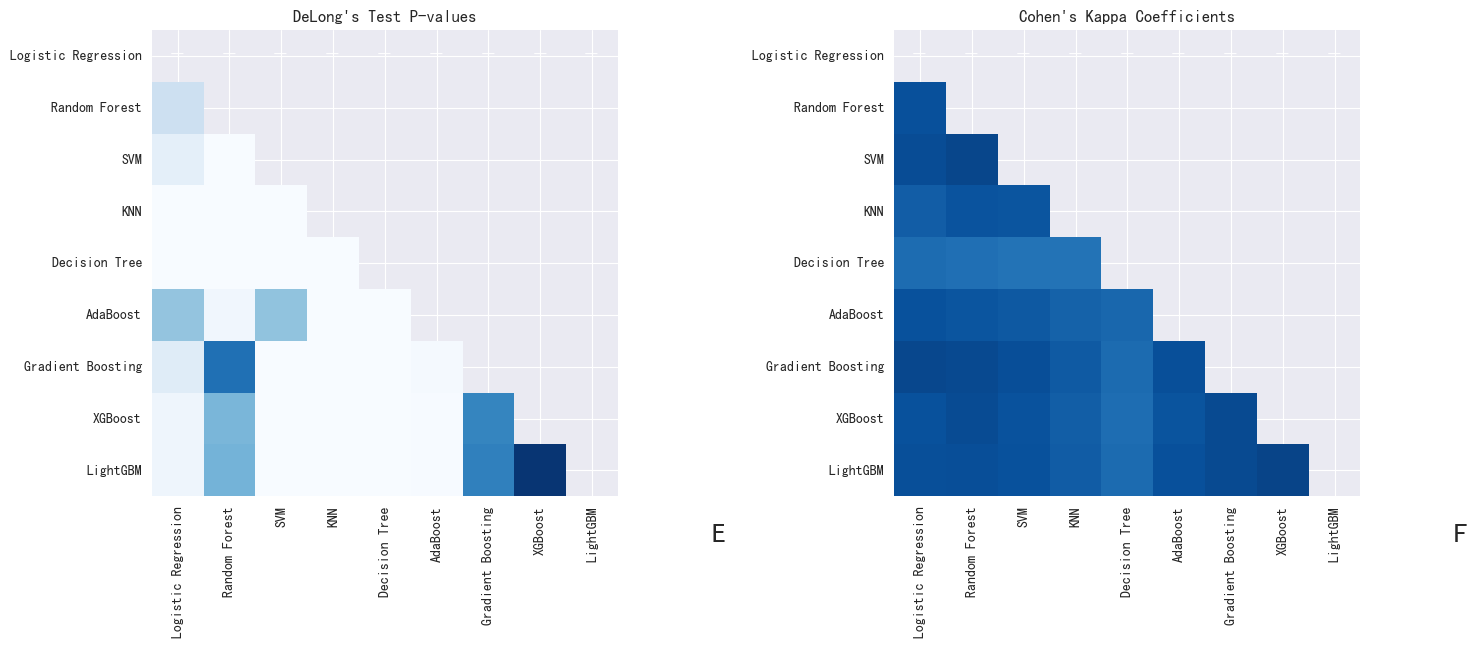

In [9]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.metrics import roc_auc_score, roc_curve, cohen_kappa_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 定义DeLong检验函数
def delong_roc_test(y_true, y_pred1, y_pred2):
    auc1 = roc_auc_score(y_true, y_pred1)
    auc2 = roc_auc_score(y_true, y_pred2)
    z = (auc1 - auc2) / np.sqrt(auc1 * (1 - auc1) / len(y_true) + auc2 * (1 - auc2) / len(y_true))
    p_value = 2 * (1 - norm.cdf(abs(z)))
    return p_value

# 假设 models, X_train, y_train, X_test, y_test 已定义
# 定义模型列表
model_names = list(models.keys())
roc_aucs = {}
y_probs = {}
y_preds = {}

# 计算每个模型的AUC和预测概率
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_prob = None

    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    roc_aucs[name] = roc_auc
    y_probs[name] = y_prob
    y_preds[name] = y_pred

# DeLong检验P值矩阵
p_matrix = np.ones((len(models), len(models)))  # 初始化为1
for i, model1 in enumerate(model_names):
    for j, model2 in enumerate(model_names):
        if i != j:
            p_matrix[i, j] = delong_roc_test(y_test, y_probs[model1], y_probs[model2])
            p_matrix[j, i] = p_matrix[i, j]  # 确保矩阵对称

# Cohen's Kappa系数矩阵
cohen_matrix = np.zeros((len(models), len(models)))
for i, model1 in enumerate(model_names):
    for j, model2 in enumerate(model_names):
        cohen_matrix[i, j] = cohen_kappa_score(y_preds[model1], y_preds[model2])

# 创建掩码矩阵
mask = np.triu(np.ones_like(p_matrix, dtype=bool))

# 创建热图
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# 绘制DeLong's Test P-values热图
sns.heatmap(p_matrix, mask=mask, annot=True, fmt=".2g", cmap='Blues', square=True,
            xticklabels=model_names, yticklabels=model_names, ax=axes[0], cbar=False, annot_kws={"size": 10},
            vmin=0, vmax=1)
axes[0].set_title("DeLong's Test P-values")
axes[0].text(1.2, -0.1, "E", transform=axes[0].transAxes, size=20, weight="bold")

# 绘制Cohen's Kappa Coefficients热图
sns.heatmap(cohen_matrix, mask=mask, annot=True, fmt=".2f", cmap='Blues', square=True,
            xticklabels=model_names, yticklabels=model_names, ax=axes[1], cbar=False, annot_kws={"size": 10},
            vmin=-1, vmax=1)
axes[1].set_title("Cohen's Kappa Coefficients")
axes[1].text(1.2, -0.1, "F", transform=axes[1].transAxes, size=20, weight="bold")

# 显示图表
plt.tight_layout()
plt.show()